In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1MKZrzC_gp42GgTyR0ePCSB1rHCmt2QdH
!gdown --id 1gNo2xpL8SFzgYWTNK_zdkivD1j0AKSgV
!gdown --id 11q8o7K6-bhbAUM8HFmqHpIGp_ipqnXGi

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1MKZrzC_gp42GgTyR0ePCSB1rHCmt2QdH
To: /content/AirQualityUCI.csv
100% 785k/785k [00:00<00:00, 52.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gNo2xpL8SFzgYWTNK_zdkivD1j0AKSgV
To: /content/data.txt
100% 3.06k/3.06k [00:00<00:00, 2.86MB/s]
Downloading...
From: https://drive.google.com/uc?id=11q8o7K6-bhbAUM8HFmqHpIGp_ipqnXGi
To: /content/dataset_57_hypothyroid.csv
100% 307k/307k [00:00<00:00, 40.5MB/s]


In [2]:
!pip install efficientnet_pytorch
!pip install albumentations
!pip install scikit-learn --upgrade

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=63fe1088d39fe9d1cb40dcf6367a9d161bc1be6501974521372efd6b9192d818
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 631 kB 6.9 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=1a7afb96ad5d7a4d8b7584145ac7b4d58c687f4101dd0c24bfed0ca9f4f1aa7f
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 23.1 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-lear

# Dependencies

In [3]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import missingno as msno
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [75]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, f1_score, precision_score, recall_score, accuracy_score

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms, models

from efficientnet_pytorch import EfficientNet

In [7]:
from pathlib import Path
import pickle
from skimage import io
import PIL
from PIL import Image
import albumentations as A

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
!nvidia-smi

Tue Oct 19 13:46:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Support

## general

In [11]:
def find_lr(model, dataloader, loss_fn, optimizer, init_value=1e-8, 
            final_value=10.0, use_gpu=True, classification=True):
    """finding optimal learning rate
    "Ian Pointer - Programming PyTorch for Deep Learning - Creating and Deploying 
    Deep Learning Applications - O’Reilly Media (2019)
    """
    model.train()
    number_in_epoch = len(dataloader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, targets in dataloader:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        if classification:
            loss = loss_fn(outputs, targets.long())
        else:
            loss = loss_fn(outputs, targets.float())

        # Crash out if loss explodes
        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs, losses

        # Record the best loss
        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr

    return log_lrs, losses

In [119]:
def train(train_loader, val_loader, model, epochs, lr, opt, classification):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {v_loss:0.4f} train_metric: {t_acc:0.4f} val_metric: {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if opt is not None:
            optimizer = opt
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.7)

        if classification & (opt is None):
            criterion = nn.CrossEntropyLoss(weight=torch.Tensor([.85, .1, .05]))
        elif classification & (opt is not None):
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.MSELoss()

        for epoch in range(epochs):
            train_loss, train_metric = fit_epoch(model, train_loader, criterion, optimizer, classification, opt)
            
            val_loss, val_metric = eval_epoch(model, val_loader, criterion, classification, opt)
            
            history.append((train_loss, train_metric, val_loss, val_metric))
            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_metric, v_acc=val_metric))
            
    return history

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, classification, opt):
    model.train()
    processed_size = 0
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    predictions = np.array([])
    real_data = np.array([])
  
    for inputs, targets in train_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        if classification:
            loss = criterion(outputs, targets.long())
        else:
            loss = criterion(outputs, targets.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

        if classification:
            preds = torch.argmax(outputs, 1).cpu().numpy().reshape(1, -1)[0]
            targets = targets.detach().cpu().numpy().reshape(1, -1)[0]
            predictions = np.hstack([predictions, preds])
            real_data = np.hstack([real_data, targets])
            # running_corrects += torch.sum(preds == targets.data)
        else:
            outputs = outputs.detach().cpu().numpy().reshape(1, -1)[0]
            targets = targets.detach().cpu().numpy().reshape(1, -1)[0]
            predictions = np.hstack([predictions, outputs])
            real_data = np.hstack([real_data, targets])
              
    train_loss = running_loss / processed_data
    if classification & (opt is None):
        train_metric = fbeta_score(real_data, predictions, average="macro", beta=2) # macro
    elif classification & (opt is not None):
        train_metric = accuracy_score(real_data, predictions)
    else:
        train_metric = mean_absolute_error(predictions, real_data)

    return train_loss, train_metric

In [14]:
def eval_epoch(model, val_loader, criterion, classification, opt):
    model.eval()
    processed_size = 0
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    predictions = np.array([])
    real_data = np.array([])

    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            if classification:
                loss = criterion(outputs, targets.long())
            else:
                loss = criterion(outputs, targets.float())

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

        if classification:
            preds = torch.argmax(outputs, 1).cpu().numpy().reshape(1, -1)[0]
            targets = targets.detach().cpu().numpy().reshape(1, -1)[0]
            predictions = np.hstack([predictions, preds])
            real_data = np.hstack([real_data, targets])
            # running_corrects += torch.sum(preds == targets.data)
        else:
            outputs = outputs.detach().cpu().numpy().reshape(1, -1)[0]
            targets = targets.detach().cpu().numpy().reshape(1, -1)[0]
            predictions = np.hstack([predictions, outputs])
            real_data = np.hstack([real_data, targets])

    val_loss = running_loss / processed_size
    if classification & (opt is None):
        val_metric = fbeta_score(real_data, predictions, average="macro", beta=2) # macro
    elif classification & (opt is not None):
        val_metric = accuracy_score(real_data, predictions)
    else:
        val_metric = mean_absolute_error(predictions, real_data)
    return val_loss, val_metric

## regression

In [15]:
# piplines with transformations
def my_pipline(cont_columns, ordinal_columns):

    pipeline_cont = Pipeline(steps=[
                                    ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_columns])),
                                    ('KNN', KNNImputer()),
                                    ('box_cox', PowerTransformer(standardize=True)),              
                                    ])

    pipeline_cat = Pipeline(steps=[
                                    ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_columns])),
                                    ("Imputer", SimpleImputer(strategy='most_frequent')),
                                    ('enc', OrdinalEncoder())
                                ])

    # union piplines
    feature_union = FeatureUnion(transformer_list = [
                                                    ("pipeline_cont", pipeline_cont),
                                                    ("pipeline_cat", pipeline_cat)
                                                    ]
                                    )

    return feature_union

In [42]:
class MySimpleRegNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x.float()))
        x = F.relu(self.fc2(x.float()))
        x = self.fc3(x.float())
        return x.float()

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [$C6H6(GT)$]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$C6H6(GT)$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.4])
  plt.legend()
  plt.show()

In [18]:
def resid_analysis(resid):
    x_fit = np.linspace(resid.min(), resid.max(), len(resid))
    loc_laplace, scale_laplace = stats.laplace.fit(resid)
    loc_norm, scale_norm = norm.fit(resid)
    print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc_laplace:.3f}, fitted std = {scale_laplace:.3f}")
    print(f"Fitting of residuals by Normal distribution: fitted mean = {loc_norm:.3f}, fitted std = {scale_norm:.3f}")
    y_fit_laplace = stats.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = stats.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplots(1, 2, figsize=(25, 5))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.subplot(1, 2, 2)
    sns.distplot(resid, bins=100, vertical=True, label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b', 
            label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g', 
            label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.tight_layout()
    plt.show()

In [19]:
def predict_regression(model, loader, mode):
    with torch.no_grad():
        model.eval()
        predictions = np.array([])
        real_data = np.array([])
    
        if mode == 'test':
            for inputs, y_real in loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs).float()

                outputs = outputs.detach().cpu().numpy().reshape(1, -1)[0]
                y_real = y_real.detach().cpu().numpy().reshape(1, -1)[0]
                predictions = np.hstack([predictions, outputs])
                real_data = np.hstack([real_data, y_real])
            return predictions, real_data
        else:
            for inputs in loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                outputs = outputs.detach().cpu().numpy().reshape(1, -1)[0]
                predictions = np.hstack([predictions, outputs])
            return predictions

## table classification

In [ ]:
class MySimpleClassNet(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x.float()))
        x = F.relu(self.fc2(x.float()))
        x = self.fc3(x.float())
        return x.float()

In [ ]:
def predict_classification(model, loader, mode):
    with torch.no_grad():
        model.eval()
        predictions = np.array([])
        real_data = np.array([])
    
        if mode == 'test':
            for inputs, targets in loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)

                preds = torch.argmax(outputs, 1).cpu().numpy().reshape(1, -1)[0]
                targets = targets.detach().cpu().numpy().reshape(1, -1)[0]
                predictions = np.hstack([predictions, preds])
                real_data = np.hstack([real_data, targets])
            return predictions, real_data
        else:
            for inputs in loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                preds = torch.argmax(outputs, 1).cpu().numpy().reshape(1, -1)[0]
                predictions = np.hstack([predictions, preds])
            return predictions

In [84]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##  pictures classification

In [109]:
# Рандомные картинки
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [110]:
# Датасет с аугментациями
class HotDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    # List of pathes to the files wich we should upload *files*
    # А также указываем какой тип датасета мы используем *DATA_MODES*
    def __init__(self, files, mode, input_size):
        super().__init__()
        self.input_size = input_size
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        # Определяем переменную для метода длины датасета
        self.len_ = len(self.files)
        
        # Определяем LabelEncoder, который по имени картинки преобразует ее в число
        self.label_encoder = LabelEncoder()
        
        # Лейблы тестового набора фалов не известны 
        if self.mode == 'train':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

        elif self.mode == 'val':
            self.labels = [path.parent.name for path in self.files]

            with open('label_encoder.pkl', 'rb') as le_dump_file:
                  self.label_encoder = pickle.load(le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # Open the picture
        image = Image.open(file)
        # Load pixels
        image.load()
        return image

    # Add padding to keep pictures proportional
    def prepare_sample(self, image):

        H = image.size[1]
        W = image.size[0]
        
        if H>W:
            image = transforms.functional.pad(image,padding=[round(abs(H-W)/2),0])
        else:
            image = transforms.functional.pad(image,padding=[0,round(abs(H-W)/2)])
            
        return image
    
    def augmentation_pipline(self, image):
        """Аугментирующие трансформации для трейна"""
        
        image = np.asarray(image)
        
        augmentation_pipeline = A.Compose(
            [
                A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
                A.OneOf(
                    [
                        A.RandomContrast(limit=0.15), # apply contrast
                        A.RandomBrightness(limit=0.15), # apply brightness
                    ],
                    p = 0.05
                )
            ],
            p = 1
        )
        
        image = augmentation_pipeline(image = image)
        image = Image.fromarray(image["image"])
        return image
  
    def __getitem__(self, index):
        # Перевод в нужный размер и в тензоры
        transform_train = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(), # auto rescaling to interval 0 to 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        transform_test = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.ToTensor(), # auto rescaling to interval 0 to 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        # load image by index
        x = self.load_sample(self.files[index])
        
        # Если тест, то лейблы не нужны
        if self.mode == 'test':
            x = self.prepare_sample(x)
            x = transform_test(x)
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            x = self.prepare_sample(x)
            x = self.augmentation_pipline(x)
            x = transform_train(x)
            return x, y

In [111]:
def chunks(lst, chunk_count):
    chunk_size = len(lst) // chunk_count
    chunk = [np.array(lst[i:i+chunk_size]) for i in range(0, len(lst), chunk_size)]
    return chunk
    
def optimizer(model, found_lr):

    amount = sum(1 for x in model.parameters())
    print(f"Number of parameters {amount}")
    for i, param in enumerate(model.parameters()):
        if (i+1) / amount < 0.5:
            param.requires_grad = False
            last = i + 2

    param_chunk = chunks(lst=list(range(last, amount+1)), chunk_count=4)

    param1 = list(model.parameters())[param_chunk[0][0]:param_chunk[0][-1]+1]
    param2 = list(model.parameters())[param_chunk[1][0]:param_chunk[1][-1]+1]
    param3 = list(model.parameters())[param_chunk[2][0]:param_chunk[2][-1]+1]
    param4 = list(model.parameters())[param_chunk[3][0]:param_chunk[3][-1]+1]

    optimizer = torch.optim.Adam(params = [
        {'params': param1, 'lr': found_lr / 100},
        {'params': param2, 'lr': found_lr / 50},
        {'params': param3, 'lr': found_lr / 10},
        {'params': param4, 'lr': found_lr}], 
        lr=found_lr, amsgrad=True)

    return optimizer

In [112]:
def predict(model, loader, mode):
    with torch.no_grad():
        logits = []
        real_y = []
    
        if mode != 'test':
            for inputs, y_real in loader:
                inputs = inputs.to(DEVICE)
                model.eval()
                outputs = model(inputs).cpu()
                logits.append(outputs)
                real_y.append(y_real.numpy())
                probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
                y_preds = np.argmax(probs,-1)
            return probs, y_preds, real_y
        else:
            for inputs in loader:
                inputs = inputs.to(DEVICE)
                model.eval()
                outputs = model(inputs).cpu()
                logits.append(outputs)
                probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
                y_preds = np.argmax(probs,-1)
            return probs, y_preds

In [113]:
def accurancy_for_each_class(y_test_all, predictions_all, loader, classes_number=2):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = sorted(set(loader.dataset.labels))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))
        
def listmerge3(lstlst):
    all=[]
    for lst in lstlst:
        all.extend(lst)
    return all

In [114]:
class ClassNetPic(nn.Module):
    def __init__(self):
        super().__init__()
        # enc_conv0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)

        # enc_conv1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # enc_conv2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # enc_conv3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)



    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.pool0(e0)

        e1 = self.enc_conv1(e0)
        e1 = self.pool1(e1)

        e2 = self.enc_conv2(e1)
        e2 = self.pool2(e2)

        e3 = self.enc_conv3(e2)
        e3 = self.pool3(e3)

        return e3

# NN Regression task

## Data preparation

Regression EDA: https://colab.research.google.com/drive/1Y9tqMccZ9R08Q8aCXjokDgmMgX7ky-G5?usp=sharing

In [20]:
# Dataset description
!head -n 22 "/content/data.txt"

Main link: https://archive.ics.uci.edu/ml/datasets/Air+Quality#
Data Set Information:
The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing

In [21]:
# Read dataset and replace all -200 values to np.nan
data = pd.read_csv("./AirQualityUCI.csv", sep=';', decimal=',', parse_dates=True)
data.drop(columns=["Unnamed: 15", "Unnamed: 16"], inplace=True)
data.dropna(inplace=True)
data.replace(-200, np.nan, inplace=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


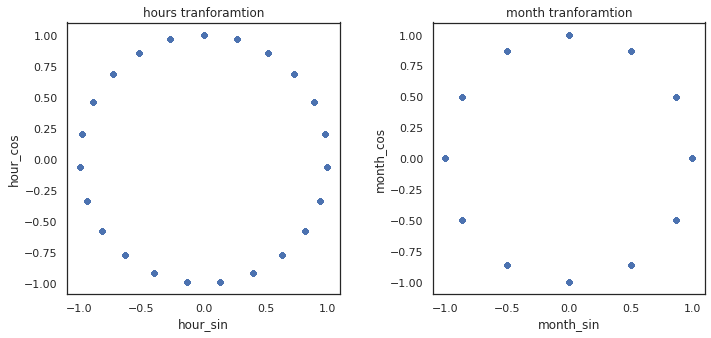

In [22]:
# We've got 2 object variables: Date and Time
# Let's extract day number, month number and hour of measurements  
data.loc[:, 'hour'] = data.loc[:, 'Time'].str[:2].astype(int)
data.loc[:, "month"] = pd.DatetimeIndex(data.loc[:, "Date"]).month
data.loc[:, "day"] = pd.DatetimeIndex(data.loc[:, "Date"]).day
data.Date = pd.to_datetime(data.Date, dayfirst=True)

# hours transformations
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/23.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/23.0)
# months  transformations
data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)

data.drop(columns=["hour", "month", "day"], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
data.plot.scatter(x='hour_sin', y='hour_cos', ax=ax1).set_aspect('equal')
ax1.set_title("hours tranforamtion")
data.plot.scatter(x='month_sin', y='month_cos', ax=ax2).set_aspect('equal')
ax2.set_title("month tranforamtion")
plt.show()

In [23]:
# drop rows with Nan in target
data.drop(data.loc[data["AH"].isnull(), :].index, inplace=True)
# drop column with NANs
data.drop(columns=["NMHC(GT)"], inplace=True)

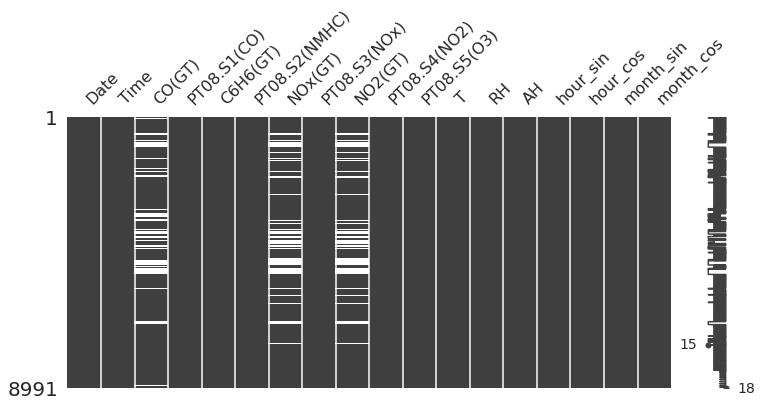

In [24]:
msno.matrix(data, figsize=(12,5))
plt.show()

In [25]:
# drop useless
# data.drop(columns=["RH"], inplace=True)
# drop columns with a lot of NaNs
# data.drop(columns=["CO(GT)", 'NO2(GT)', 'NOx(GT)'], inplace=True)

In [26]:
# split data
data.Date = pd.to_datetime(data.Date, dayfirst=True)
train = data.loc[(data.Date >= "2004-03-10") & (data.Date <= "2005-02-10")]
test = data.loc[data.Date > "2005-02-10"]

test_share = test.shape[0]/(train.shape[0]+test.shape[0])

print(f"there are {test_share*100:.03}% of observations in our test sample")

train.drop(columns=["Date", "Time"], inplace=True)
test.drop(columns=["Date", "Time"], inplace=True)

# x/y
x_train, y_train = train.drop(columns=['C6H6(GT)']), train.loc[:, ["C6H6(GT)"]]
x_test, y_test = test.drop(columns=['C6H6(GT)']), test.loc[:, ["C6H6(GT)"]]

there are 13.8% of observations in our test sample


In [27]:
# Y transformation
transformer_y = PowerTransformer(standardize=True)
y_train = transformer_y.fit_transform(y_train)
y_test = transformer_y.transform(y_test)

# X transformation
imputer = KNNImputer(n_neighbors=5)
x_train = pd.DataFrame(data=imputer.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(data=imputer.transform(x_test), columns=x_test.columns)

transformer = PowerTransformer(standardize=True)
x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)

## Keras

### Model Initialization

In [30]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

### Fitting Model

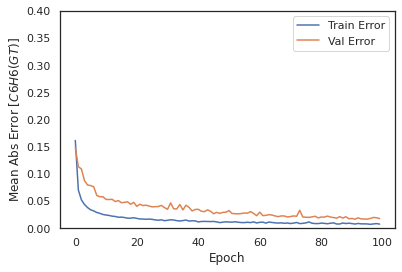

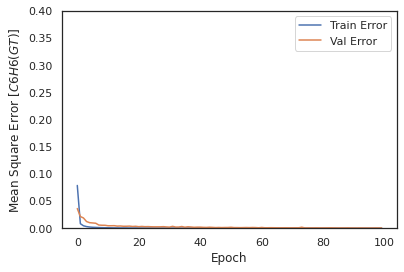

In [34]:
history = model.fit(
  x_train, y_train,
  epochs=100, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])

plot_history(history)

### Making Predictions

In [35]:
test_predictions = model.predict(x_test)

In [39]:
predictions = pd.DataFrame(np.hstack([test_predictions, y_test]), columns=["predictions", "target"])

In [40]:
predictions["target"] = transformer_y.inverse_transform(predictions[["target"]])
predictions["predictions"] = transformer_y.inverse_transform(predictions[["predictions"]])

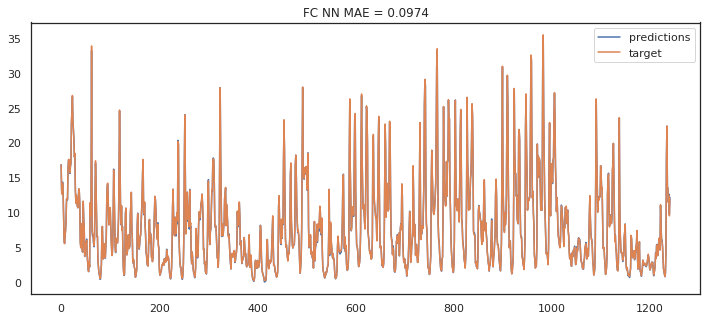

In [41]:
mae = mean_absolute_error(predictions["target"], predictions["predictions"])
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
predictions.plot(ax=axes)
plt.title(f"FC NN MAE = {mae:0.03}")
plt.show()

### Analyzing Errors

In [43]:
predictions["resids"] = predictions["target"] - predictions["predictions"]

Fitting of residuals by Laplace distribution: fitted mean = 0.022, fitted std = 0.095
Fitting of residuals by Normal distribution: fitted mean = 0.025, fitted std = 0.129


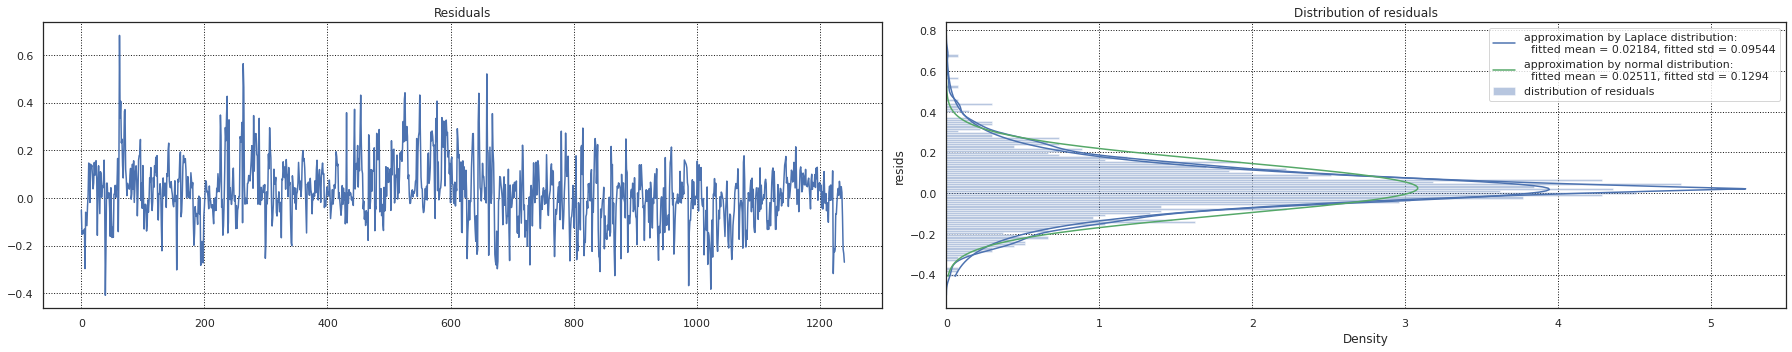

In [44]:
resid_analysis(predictions["resids"])

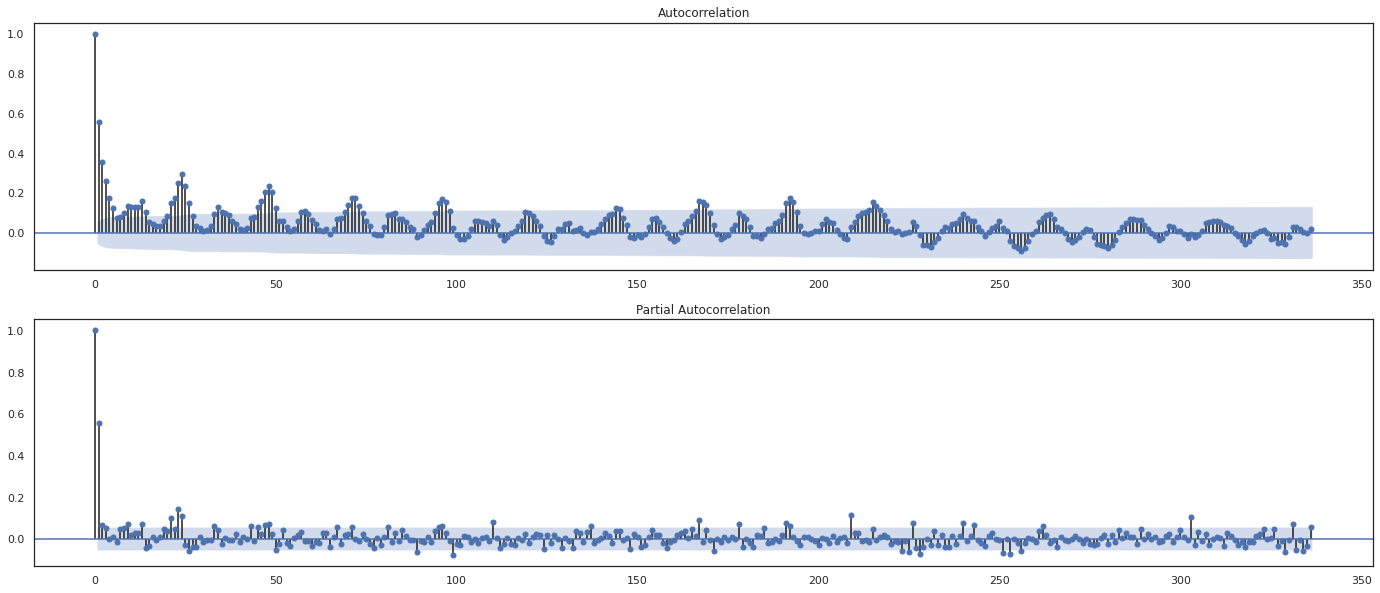

In [45]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(predictions["resids"].values.squeeze(), lags=24*7*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(predictions["resids"].values.squeeze(), lags=24*7*2, ax=ax2)

## PyTorch

### Creating Torch Dataset

In [46]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [47]:
train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test)

batch_size = 256
n_features = x_train.shape[1]

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True, shuffle=False)

In [48]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([256, 15]), torch.Size([256, 1]))

### Model Initialization

In [49]:
simple_reg_net = MySimpleRegNet(n_features)
simple_reg_net.to(DEVICE)

MySimpleRegNet(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [50]:
summary(simple_reg_net, (n_features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [256, 64]           1,024
            Linear-2                  [256, 64]           4,160
            Linear-3                   [256, 1]              65
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.25
Params size (MB): 0.02
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Tuning learning rate

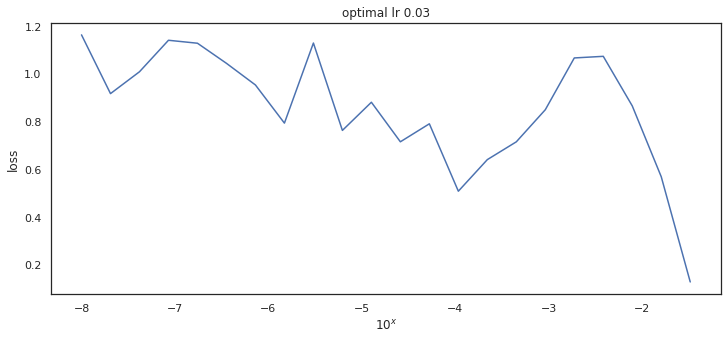

In [52]:
# finding optimal lr
logs, losses = find_lr(simple_reg_net, dataloader=train_loader, loss_fn=nn.MSELoss(),
                       optimizer=torch.optim.Adam(simple_reg_net.parameters()), classification=False)

# plot lr
fig = plt.figure(figsize=(12,5))
plt.plot(logs, losses)
plt.xlabel("$10^x$")
plt.ylabel("loss")
plt.title(f"optimal lr {10**logs[losses.index(min(losses))]:0.01}")
plt.show()

### Fitting Model

In [60]:
history = train(train_loader=train_loader, val_loader=test_loader, opt=None,
                model=simple_reg_net, epochs=100, lr=0.0001, classification=False)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.4453 val_loss: 1.6738 train_metric: 0.8274 val_metric: 1.0468

Epoch 002 train_loss: 1.0066 val_loss: 1.2103 train_metric: 0.6886 val_metric: 0.8841

Epoch 003 train_loss: 0.7179 val_loss: 0.8861 train_metric: 0.5818 val_metric: 0.7536

Epoch 004 train_loss: 0.5171 val_loss: 0.6536 train_metric: 0.4949 val_metric: 0.6464

Epoch 005 train_loss: 0.3758 val_loss: 0.4851 train_metric: 0.4243 val_metric: 0.5568

Epoch 006 train_loss: 0.2762 val_loss: 0.3628 train_metric: 0.3670 val_metric: 0.4820

Epoch 007 train_loss: 0.2062 val_loss: 0.2744 train_metric: 0.3211 val_metric: 0.4199

Epoch 008 train_loss: 0.1573 val_loss: 0.2111 train_metric: 0.2852 val_metric: 0.3693

Epoch 009 train_loss: 0.1233 val_loss: 0.1662 train_metric: 0.2574 val_metric: 0.3285

Epoch 010 train_loss: 0.0998 val_loss: 0.1343 train_metric: 0.2359 val_metric: 0.2961

Epoch 011 train_loss: 0.0836 val_loss: 0.1119 train_metric: 0.2194 val_metric: 0.2708

Epoch 012 train_loss: 0.0723 val_loss: 0.0

In [61]:
history = pd.DataFrame(history, columns=['train_loss', 'train_mae', 'val_loss', 'val_mae'])

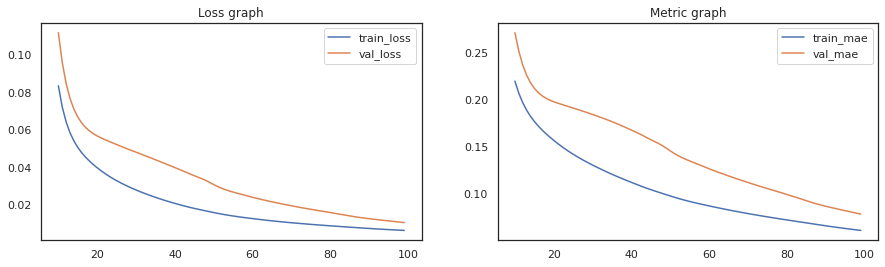

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
history.loc[10:, ["train_loss", "val_loss"]].plot(ax=axes[0])
history.loc[10:, ["train_mae", "val_mae"]].plot(ax=axes[1])
axes[0].set_title("Loss graph")
axes[1].set_title("Metric graph")
plt.show()

### Making Predictions

In [63]:
predictions = predict_regression(model=simple_reg_net, loader=test_loader, mode="test")
predictions = pd.DataFrame(np.array(predictions).T, columns=['target', 'predictions'])

In [64]:
predictions["target"] = transformer_y.inverse_transform(predictions[["target"]])
predictions["predictions"] = transformer_y.inverse_transform(predictions[["predictions"]])

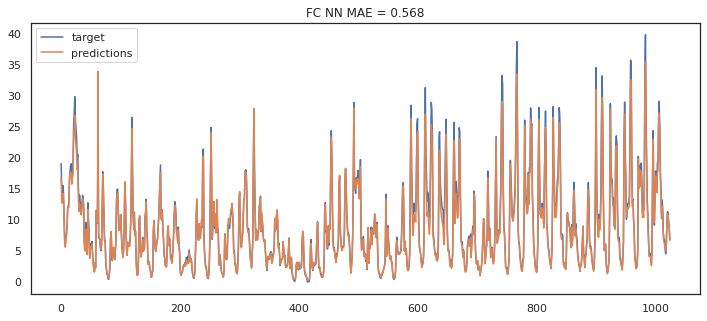

In [65]:
mae = mean_absolute_error(predictions["target"], predictions["predictions"])
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
predictions.plot(ax=axes)
plt.title(f"FC NN MAE = {mae:0.03}")
plt.show()

### Analyzing Errors

In [66]:
predictions["resids"] = predictions["target"] - predictions["predictions"]

Fitting of residuals by Laplace distribution: fitted mean = 0.218, fitted std = 0.519
Fitting of residuals by Normal distribution: fitted mean = 0.431, fitted std = 0.876


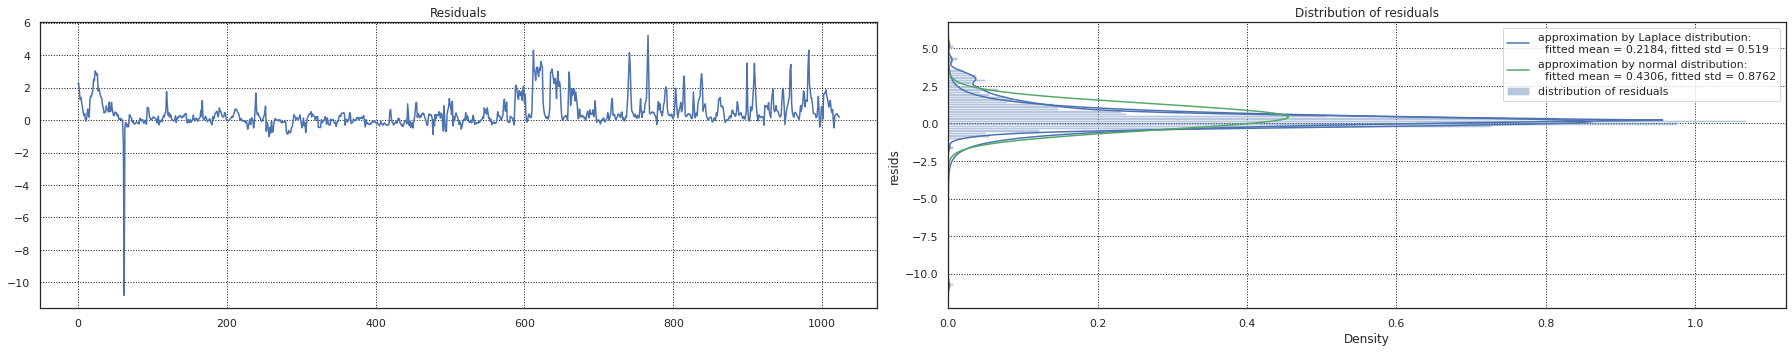

In [67]:
resid_analysis(predictions["resids"])

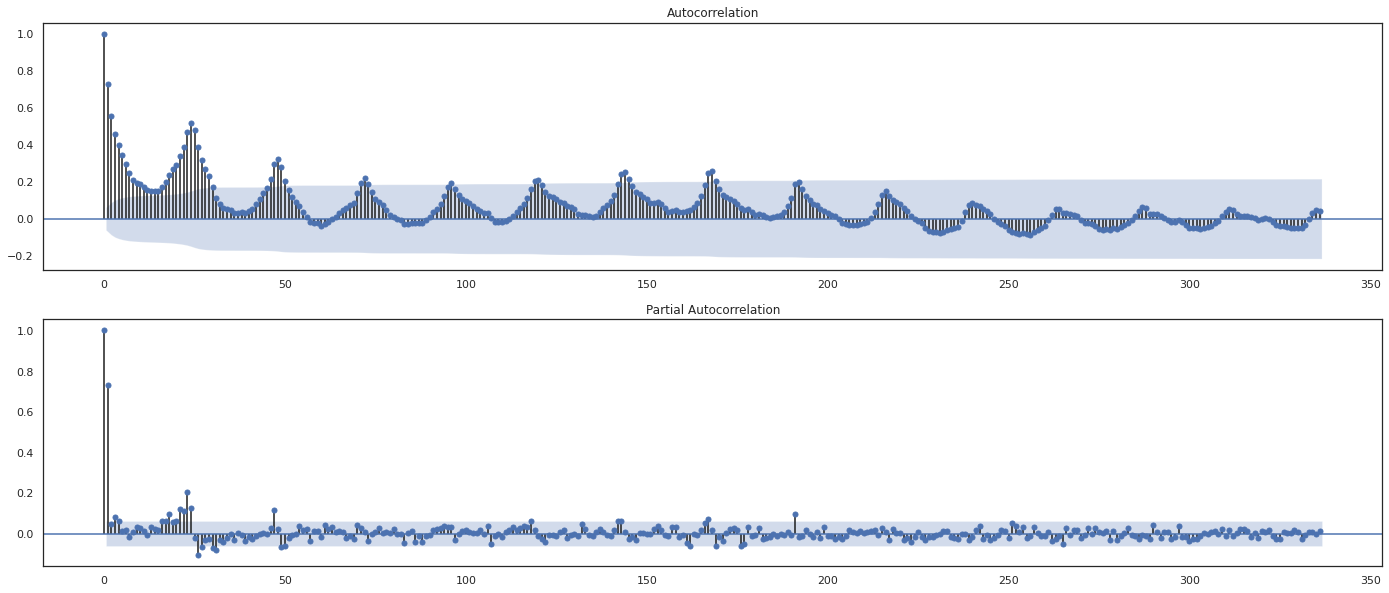

In [68]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(predictions["resids"].values.squeeze(), lags=24*7*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(predictions["resids"].values.squeeze(), lags=24*7*2, ax=ax2)

# NN Classification task

## Data preparation

In [69]:
# Read dataset and replace all -? values to np.nan
data = pd.read_csv("/content/dataset_57_hypothyroid.csv", sep=',', decimal='.', parse_dates=True, na_values="?")
data.drop(columns=["TSH_measured", "T3_measured", "TT4_measured",
                   "T4U_measured", "FTI_measured", "TBG_measured",
                   "TBG", "referral_source", "age", "hypopituitary", 
                   "goitre", "lithium"], inplace=True)
data = data.loc[~(data["Class"]=="secondary_hypothyroid")]

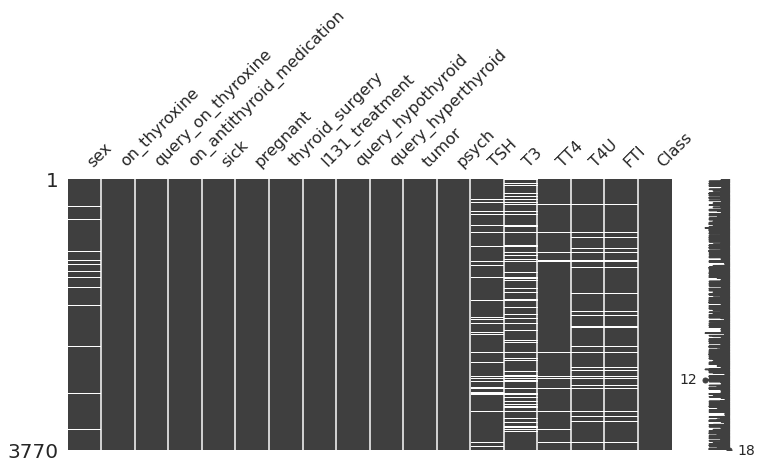

In [ ]:
msno.matrix(data, figsize=(12,5))
plt.show()

In [70]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=['Class']), data.loc[:, ['Class']], 
                                                    random_state=42, test_size=0.2, stratify=data.loc[:, ['Class']], 
                                                    shuffle=True) 

In [71]:
cont_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']

ordinal_columns = ['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'tumor',
       'psych']

In [72]:
pipeline_final = my_pipline(cont_columns=cont_columns, ordinal_columns=ordinal_columns)
x_train = pipeline_final.fit_transform(x_train)
x_test = pipeline_final.transform(x_test)

In [73]:
encoder_y = LabelEncoder()
y_train_enc = encoder_y.fit_transform(y_train)
y_test_enc = encoder_y.transform(y_test)

## Keras

### Model Initialization

In [77]:
ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train).todense()
y_test_ohe = ohe.transform(y_test).todense()

In [95]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[x_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
            metrics=['acc', f1_m])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1152      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 9,859
Trainable params: 9,859
Non-trainable params: 0
_________________________________________________________________


### Fitting Model

In [99]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, y_train_ohe,
                    epochs=100, 
                    validation_split = 0.2,
                    callbacks=[early_stop])

Epoch 1/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0458 - acc: 0.9805 - f1_m: 0.9806 - val_loss: 0.0769 - val_acc: 0.9719 - val_f1_m: 0.9717
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0398 - acc: 0.9842 - f1_m: 0.9844 - val_loss: 0.0733 - val_acc: 0.9685 - val_f1_m: 0.9693
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0427 - acc: 0.9826 - f1_m: 0.9831 - val_loss: 0.0929 - val_acc: 0.9702 - val_f1_m: 0.9693
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0402 - acc: 0.9834 - f1_m: 0.9836 - val_loss: 0.0878 - val_acc: 0.9685 - val_f1_m: 0.9677
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0492 - acc: 0.9797 - f1_m: 0.9794 - val_loss: 0.1212 - val_acc: 0.9669 - val_f1_m: 0.9666
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0413 - acc: 0.9822 - f1_m: 0.9827 - val_loss: 0.0845 - val_acc: 0.9719 - val_f1_m: 0.9718
Epoch 7/10

### Making Predictions

In [100]:
y_pred = model.predict(x_test, batch_size=32)
y_pred_bool = np.argmax(y_pred, axis=1)

In [103]:
# rf results
# RF from the box better than tunned LR
prec_rf_micro = precision_score(y_test_enc, y_pred_bool, average="micro")
recall_rf_micro = recall_score(y_test_enc, y_pred_bool, average="micro")

prec_rf_macro = precision_score(y_test_enc, y_pred_bool, average="macro")
recall_rf_macro = recall_score(y_test_enc, y_pred_bool, average="macro")

f1_macro_rf = f1_score(y_test_enc, y_pred_bool, average='macro')

print(f"precision_score micro: {prec_rf_micro:0.02}, recall_score micro: {recall_rf_micro:0.02}")
print(f"precision_score macro: {prec_rf_macro:0.02}, recall_score macro: {recall_rf_macro:0.02}")
print(f"f1_score: {f1_macro_rf:0.02}")

precision_score micro: 0.98, recall_score micro: 0.98
precision_score macro: 0.91, recall_score macro: 0.9
f1_score: 0.91


## PyTorch

### Creating Torch Dataset

In [ ]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train_enc = torch.from_numpy(y_train_enc)
y_test_enc = torch.from_numpy(y_test_enc)

In [ ]:
train = TensorDataset(x_train, y_train_enc)
test = TensorDataset(x_test, y_test_enc)

batch_size = 64
n_features = x_train.shape[1]

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

### Model Initialization

In [ ]:
simple_class_net = MySimpleClassNet(n_features)
simple_class_net.to(DEVICE)

MySimpleClassNet(
  (fc1): Linear(in_features=17, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
summary(simple_class_net, (n_features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 32]             576
            Linear-2                   [64, 32]           1,056
            Linear-3                    [64, 3]              99
Total params: 1,731
Trainable params: 1,731
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


### Tuning learning rate

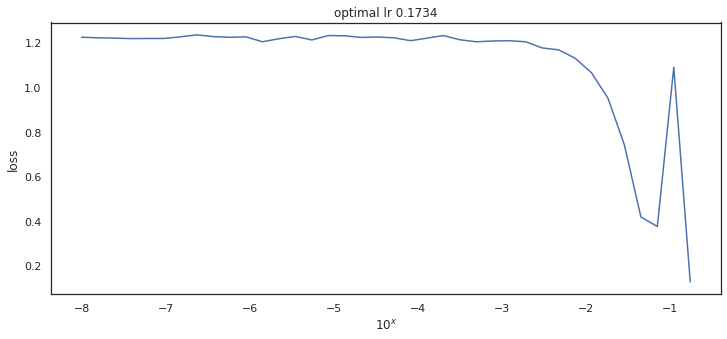

In [ ]:
# finding optimal lr
logs, losses = find_lr(simple_class_net, dataloader=train_loader, loss_fn=nn.CrossEntropyLoss(), 
                       optimizer=torch.optim.Adam(simple_class_net.parameters()))

# plot lr
fig = plt.figure(figsize=(12,5))
plt.plot(logs, losses)
plt.xlabel("$10^x$")
plt.ylabel("loss")
plt.title(f"optimal lr {10**logs[losses.index(min(losses))]:0.04}")
plt.show()

### Fitting Model

In [ ]:
history = train(train_loader=train_loader, val_loader=test_loader, model=simple_class_net, epochs=100, lr=0.01, classification=True)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

iei

Epoch 001 train_loss: 0.1132 val_loss: 0.0887 train_metric: 0.9521 val_metric: 0.9668

Epoch 002 train_loss: 0.0818 val_loss: 0.0715 train_metric: 0.9711 val_metric: 0.9744

Epoch 003 train_loss: 0.0705 val_loss: 0.0668 train_metric: 0.9737 val_metric: 0.9758

Epoch 004 train_loss: 0.0608 val_loss: 0.0709 train_metric: 0.9780 val_metric: 0.9756

Epoch 005 train_loss: 0.0558 val_loss: 0.0711 train_metric: 0.9784 val_metric: 0.9727

Epoch 006 train_loss: 0.0534 val_loss: 0.0757 train_metric: 0.9800 val_metric: 0.9712

Epoch 007 train_loss: 0.0493 val_loss: 0.0743 train_metric: 0.9820 val_metric: 0.9740

Epoch 008 train_loss: 0.0517 val_loss: 0.0828 train_metric: 0.9821 val_metric: 0.9693

Epoch 009 train_loss: 0.0506 val_loss: 0.1041 train_metric: 0.9824 val_metric: 0.9641

Epoch 010 train_loss: 0.0508 val_loss: 0.1082 train_metric: 0.9804 val_metric: 0.9625

Epoch 011 train_loss: 0.0478 val_loss: 0.0878 train_metric: 0.9837 val_metric: 0.9678

Epoch 012 train_loss: 0.0467 val_loss:

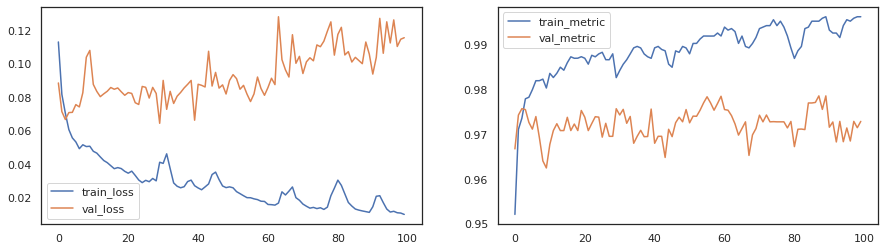

In [ ]:
history = pd.DataFrame(history, columns=['train_loss', 'train_metric', 'val_loss', 'val_metric'])

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
history.loc[:, ["train_loss", "val_loss"]].plot(ax=axes[0])
history.loc[:, ["train_metric", "val_metric"]].plot(ax=axes[1])
plt.show()

### Making Predictions

In [ ]:
predictions, real_data = predict_classification(model=simple_class_net, loader=test_loader, mode="test")

In [ ]:
# rf results
# RF from the box better than tunned LR
prec_rf_micro = precision_score(real_data, predictions, average="micro")
recall_rf_micro = recall_score(real_data, predictions, average="micro")

prec_rf_macro = precision_score(real_data, predictions, average="macro")
recall_rf_macro = recall_score(real_data, predictions, average="macro")

f1_macro_rf = f1_score(real_data, predictions, average='macro')

print(f"precision_score micro: {prec_rf_micro:0.02}, recall_score micro: {recall_rf_micro:0.02}")
print(f"precision_score macro: {prec_rf_macro:0.02}, recall_score macro: {recall_rf_macro:0.02}")
print(f"f1_score: {f1_macro_rf:0.02}")

precision_score micro: 0.97, recall_score micro: 0.97
precision_score macro: 0.89, recall_score macro: 0.86
f1_score: 0.87


# Hotdogs Classification

## Pytorch

### Model Initialization

In [104]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
model = model.to(DEVICE)
input_size = 224

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


### Creating Dataset

In [105]:
# unzip folder
!unzip -q "/content/gdrive/MyDrive/EPAM/Week 11. NN CV/HW/data/hotdog__not_hotdog.zip"

In [106]:
# types of dataset
DATA_MODES = ['train', 'test', 'val']

# path to folders with train and test pictures
TRAIN_DIR = Path('./hotdog__not_hotdog/train')
TEST_DIR = Path('./hotdog__not_hotdog/test')

# PAth to specific file
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

# List of lables
train_val_labels = [path.parent.name for path in train_val_files]
n_classes = len(np.unique(train_val_labels))

In [107]:
np.unique(train_val_labels, return_counts=True)

(array(['hot_dog', 'not_hot_dog'], dtype='<U11'), array([249, 249]))

In [115]:
train_dataset = HotDataset(train_val_files, mode='train', input_size=input_size)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)

val_dataset = HotDataset(test_files, mode='val', input_size=input_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)

# test_dataset = HotDataset(test_files, mode="test", input_size=input_size)
# test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

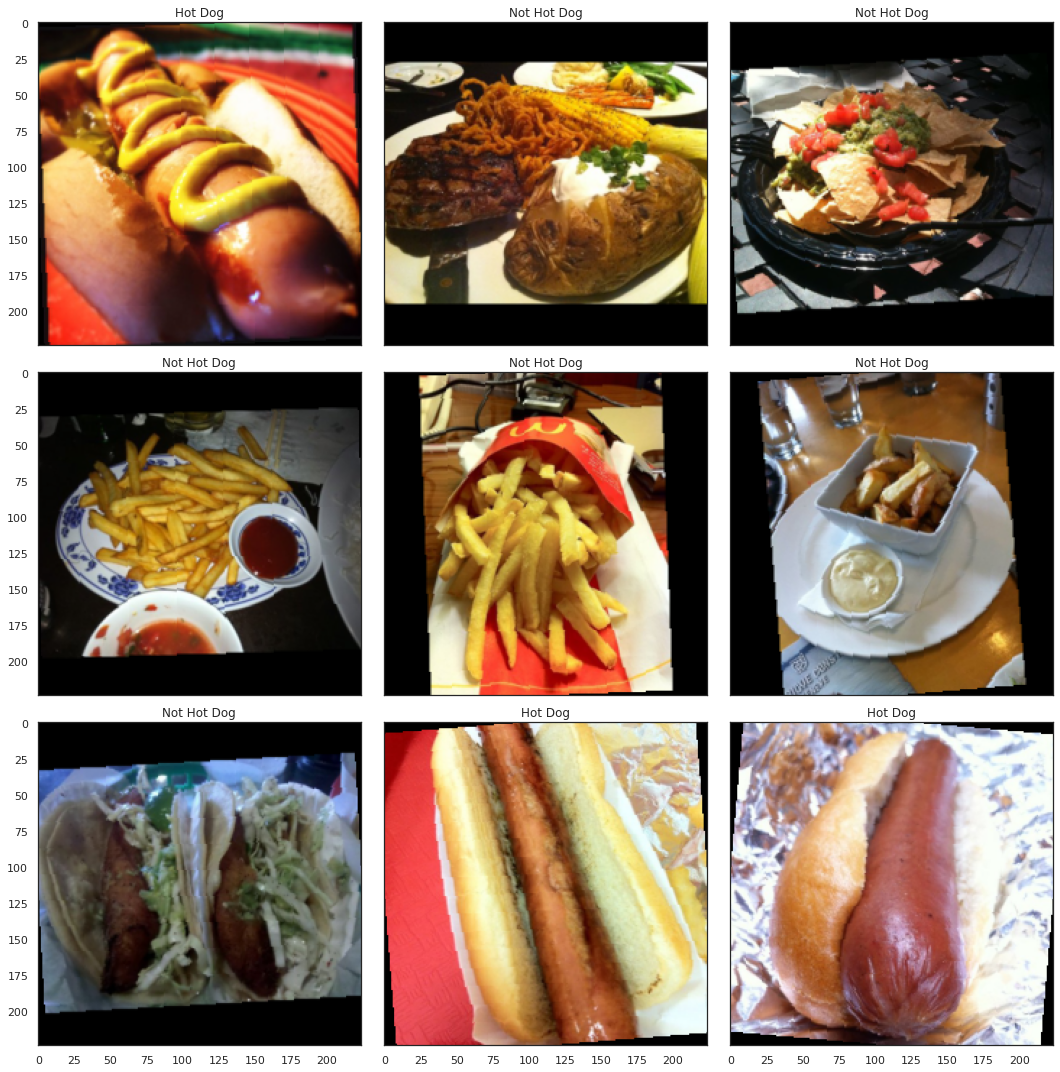

In [116]:
# Рисуем 9 рандомных объектов
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,249*2))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)
plt.tight_layout()
plt.show()

### Tuning learning rate

In [117]:
# Поиск эффективного lr для модели
logs, losses = find_lr(model=model, dataloader=train_loader, loss_fn=nn.CrossEntropyLoss(), 
                       optimizer=torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True))

index = losses.index(min(losses))
found_lr = logs[index]
found_lr = 10**found_lr

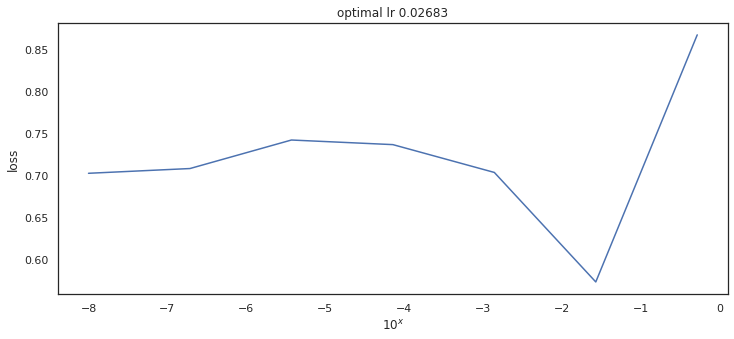

In [118]:
# plot lr
fig = plt.figure(figsize=(12,5))
plt.plot(logs, losses)
plt.xlabel("$10^x$")
plt.ylabel("loss")
plt.title(f"optimal lr {10**logs[losses.index(min(losses))]:0.04}")
plt.show()

### Optimizer initialization

In [120]:
opt = optimizer(model=model, found_lr=found_lr)

Number of parameters 213


### Fitting Model

In [121]:
# Обучаем модель
history = train(train_loader=train_loader, val_loader=val_loader, model=model, epochs=150, lr=0.001, opt=opt, classification=True)

epoch:   0%|          | 0/150 [00:00<?, ?it/s]


Epoch 001 train_loss: 6.8030 val_loss: 6217305557665331200.0000 train_metric: 0.5040 val_metric: 0.5000

Epoch 002 train_loss: 1.7691 val_loss: 404183498027434.0000 train_metric: 0.5201 val_metric: 0.5000

Epoch 003 train_loss: 1.4061 val_loss: 3074538954817.5361 train_metric: 0.5020 val_metric: 0.5000

Epoch 004 train_loss: 1.9716 val_loss: 126096996171.7760 train_metric: 0.5582 val_metric: 0.5000

Epoch 005 train_loss: 1.3202 val_loss: 2972349001.7280 train_metric: 0.5120 val_metric: 0.5000

Epoch 006 train_loss: 1.4291 val_loss: 116725835.7360 train_metric: 0.5221 val_metric: 0.4700

Epoch 007 train_loss: 1.6394 val_loss: 5474820.1380 train_metric: 0.5060 val_metric: 0.4500

Epoch 008 train_loss: 1.0805 val_loss: 3870153.0880 train_metric: 0.5261 val_metric: 0.5000

Epoch 009 train_loss: 1.1917 val_loss: 838583.1040 train_metric: 0.5382 val_metric: 0.5000

Epoch 010 train_loss: 1.1931 val_loss: 197124.1960 train_metric: 0.5582 val_metric: 0.5000

Epoch 011 train_loss: 1.0475 val_lo

Something is going wrong, but i dont know what exactly i'm doing wrong here 

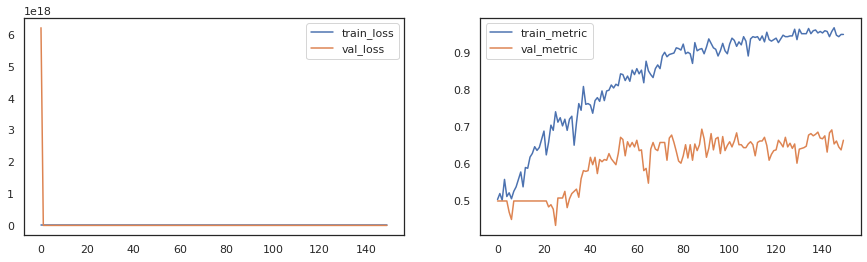

In [122]:
history = pd.DataFrame(history, columns=['train_loss', 'train_metric', 'val_loss', 'val_metric'])

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
history.loc[:, ["train_loss", "val_loss"]].plot(ax=axes[0])
history.loc[:, ["train_metric", "val_metric"]].plot(ax=axes[1])
plt.show()

### Save weights

In [ ]:
# сохраняем модель 
PATH = "/content/gdrive/MyDrive/EPAM/Week 11. NN CV/HW/model/model_weights.pth"
torch.save(model.state_dict(), PATH) 

### Making Predictions

In [123]:
# предсказываем для трейна
probs, y_preds, real_y = predict(model=model, loader=val_loader, mode="train")
real = np.array(listmerge3(real_y))

errors_list = np.array(range(y_preds.shape[0]))[y_preds != real]
print(len(errors_list))

# accurancy_for_each_class для трейна
accurancy_for_each_class(y_test_all=real, predictions_all=y_preds, loader=val_loader)

166
[154, 346]
2
Accuracy of hot_dog : 77 %
Accuracy of not_hot_dog : 62 %


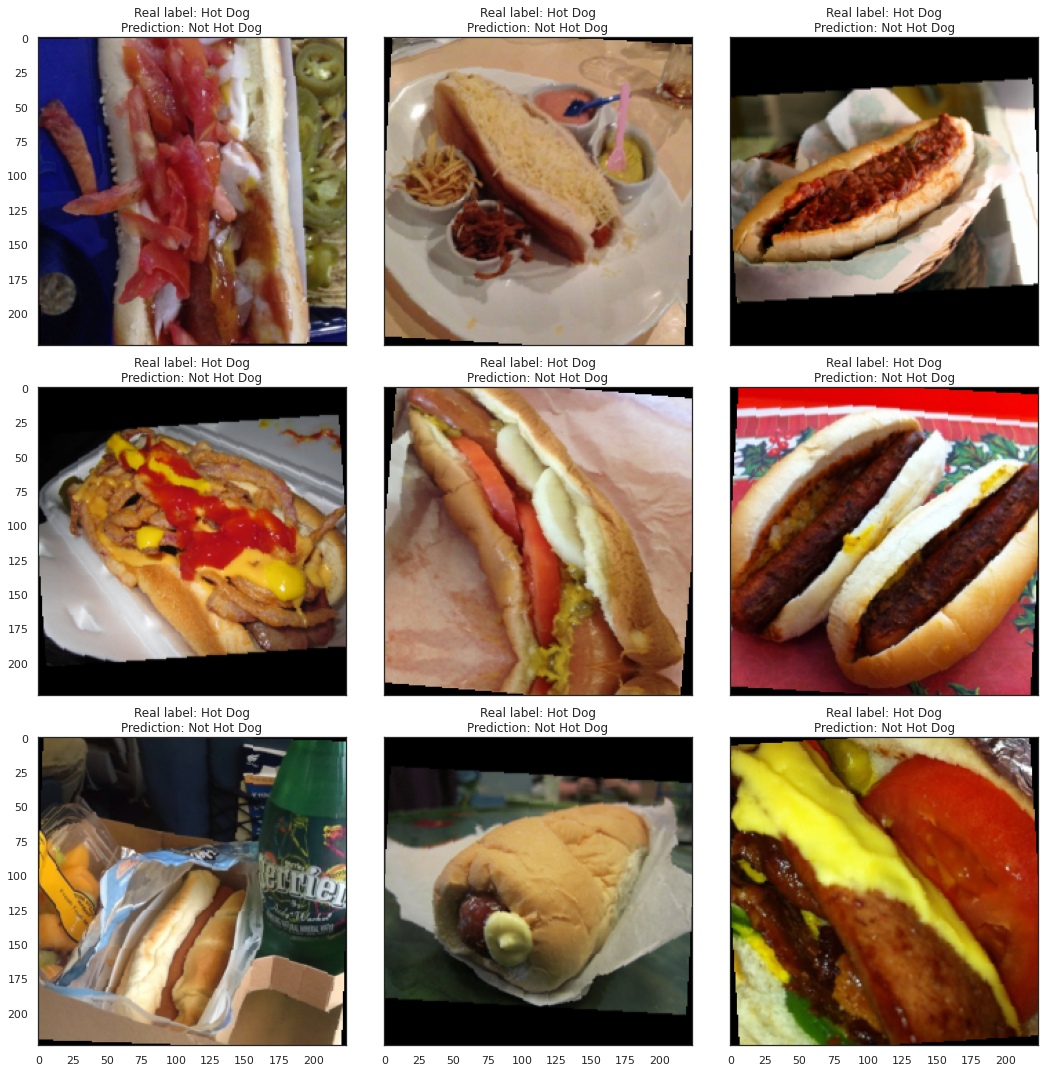

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    error_index = int(np.random.choice(errors_list))
    im_val, label_real = train_dataset[error_index]
    label_pred =  y_preds[error_index]
    label_pred = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label_pred])[0].split('_')))
    label_real = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label_real])[0].split('_')))
    
    imshow(im_val.data.cpu(), title=f"Real label: {label_real}" + "\n" + f"Prediction: {label_pred}", plt_ax=fig_x)
plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.empty_cache()

## TensorFlow

### Creating Dataset

In [ ]:
# unzip folder
!unzip -q "/content/gdrive/MyDrive/EPAM/Week 11. NN CV/HW/data/hotdog__not_hotdog.zip"

In [ ]:
# types of dataset
DATA_MODES = ['train', 'test', 'val']

# path to folders with train and test pictures
train_dir = Path('./hotdog__not_hotdog/train')
validation_dir = Path('./hotdog__not_hotdog/test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 498 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


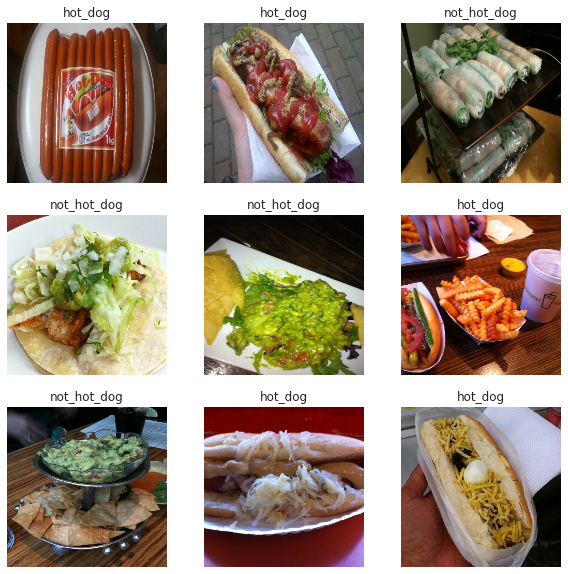

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

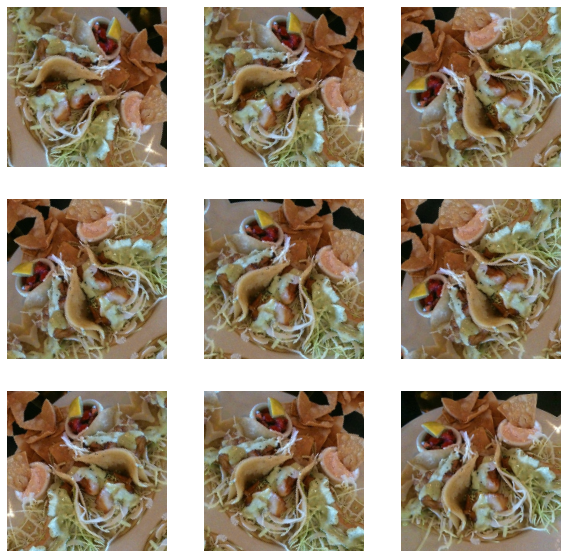

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### Model Initialization

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Fitting Model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 2s 33ms/step - loss: 0.6634 - accuracy: 0.5941


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.59


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
16/16 [==============================] - 5s 96ms/step - loss: 0.7063 - accuracy: 0.5663 - val_loss: 0.6111 - val_accuracy: 0.6510
Epoch 2/20
16/16 [==============================] - 2s 93ms/step - loss: 0.6390 - accuracy: 0.6285 - val_loss: 0.5783 - val_accuracy: 0.7054
Epoch 3/20
16/16 [==============================] - 2s 90ms/step - loss: 0.6396 - accuracy: 0.6185 - val_loss: 0.5608 - val_accuracy: 0.7054
Epoch 4/20
16/16 [==============================] - 2s 93ms/step - loss: 0.5887 - accuracy: 0.6667 - val_loss: 0.5093 - val_accuracy: 0.7500
Epoch 5/20
16/16 [==============================] - 2s 88ms/step - loss: 0.5509 - accuracy: 0.6867 - val_loss: 0.5060 - val_accuracy: 0.7599
Epoch 6/20
16/16 [==============================] - 2s 90ms/step - loss: 0.5346 - accuracy: 0.7028 - val_loss: 0.4688 - val_accuracy: 0.7970
Epoch 7/20
16/16 [==============================] - 2s 93ms/step - loss: 0.5272 - accuracy: 0.7229 - val_loss: 0.4444 - val_accuracy: 0.8292
Epoch 8/20
16

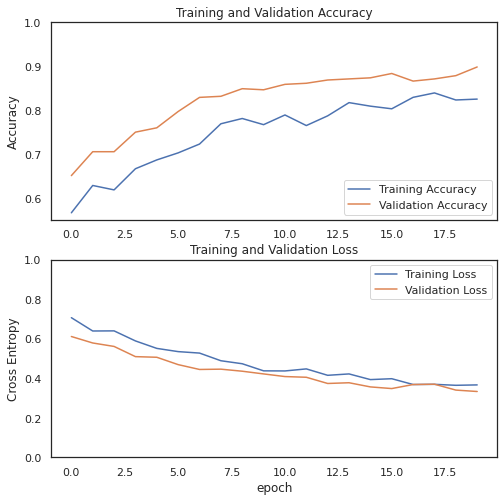

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/45
16/16 [==============================] - 5s 134ms/step - loss: 0.3326 - accuracy: 0.8494 - val_loss: 0.3404 - val_accuracy: 0.8960
Epoch 21/45
16/16 [==============================] - 2s 90ms/step - loss: 0.3804 - accuracy: 0.8333 - val_loss: 0.3378 - val_accuracy: 0.8960
Epoch 22/45
16/16 [==============================] - 2s 87ms/step - loss: 0.3587 - accuracy: 0.8454 - val_loss: 0.3245 - val_accuracy: 0.8985
Epoch 23/45
16/16 [==============================] - 2s 89ms/step - loss: 0.3414 - accuracy: 0.8293 - val_loss: 0.3211 - val_accuracy: 0.8960
Epoch 24/45
16/16 [==============================] - 2s 88ms/step - loss: 0.3602 - accuracy: 0.8353 - val_loss: 0.3218 - val_accuracy: 0.8911
Epoch 25/45
16/16 [==============================] - 2s 94ms/step - loss: 0.3703 - accuracy: 0.8353 - val_loss: 0.3344 - val_accuracy: 0.8911
Epoch 26/45
16/16 [==============================] - 2s 88ms/step - loss: 0.3577 - accuracy: 0.8474 - val_loss: 0.3227 - val_accuracy: 0.8911
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

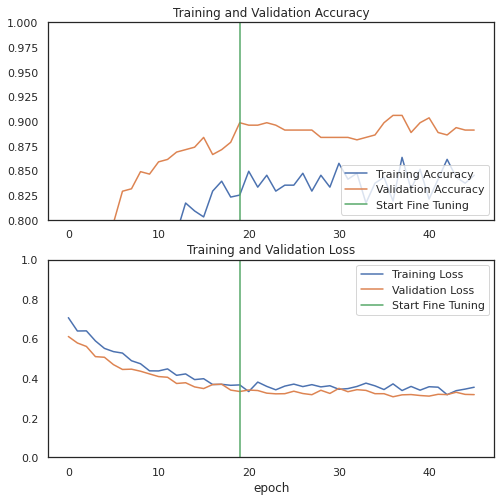

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 0s 49ms/step - loss: 0.3247 - accuracy: 0.9167
Test accuracy : 0.9166666865348816


Predictions:
 [0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0]
Labels:
 [0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0]


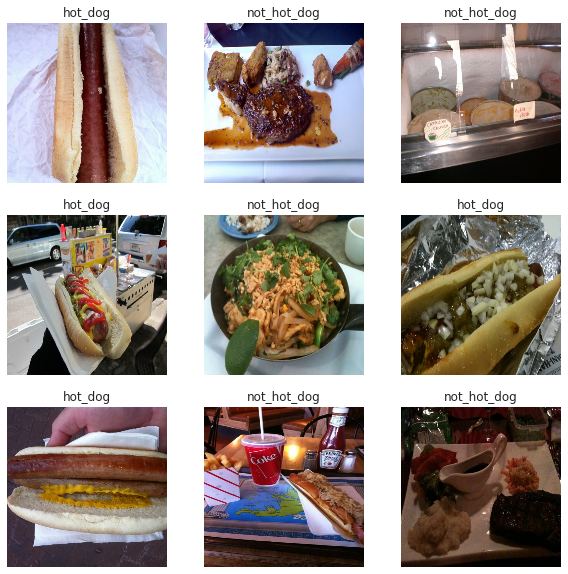

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")